In [1]:
from scipy.integrate import odeint
import numpy as np
import matplotlib.pyplot as plt
from ddeint import ddeint

from scipy.sparse import random
from scipy import stats
import math
import scipy.io
import seaborn as sns
import pandas as pd
from statistics import mean

### Lyapunov exponent for Mackey-Glass equation

In [4]:
def generate_MG_data(init_val, tau, a, b, n, times):
    def MackeyGlass(z, t):
        return (a * z(t - tau)) / (1 + z(t - tau)**n) - b*z(t)

    def initial(t):
        return init_val
    
    start, stop, step_size = times
    time_space = np.arange(start, stop, step_size)

    z_solution_new = ddeint(MackeyGlass, initial, time_space)
    z_solution_new  = [ data_pt[0] for data_pt in z_solution_new[1:] ]
    z_solution_new.insert(0, init_val)
    z_solution_new = [ np.tanh(unshifted_val-1) for unshifted_val in z_solution_new ]
    
    return np.array(z_solution_new)

tau = 17
n = 10
a = 0.2
b = 0.1

init_val = 1.2

delta = 10**(-6)
times = (0, 2000, 1)

MG_traject_ref = generate_MG_data(init_val, tau, a, b, n, times)
MG_traject_perturbed = generate_MG_data(init_val+delta, tau, a, b, n, times)

d1 = np.linalg.norm(MG_traject_ref[1600:1617] - MG_traject_perturbed[1600:1617])
d2 = np.linalg.norm(MG_traject_ref[1800:1817] - MG_traject_perturbed[1800:1817])

ld = np.log(d2/d1)/200

print("Lyapunov exponent for original Mackey-Glass is ", ld)

Lyapunov exponent for original Mackey-Glass is  0.0053078773631523015


### ESN helper functions - as lists, without data generator

In [9]:
# esn helper functions
def gen_matrix(shape, sparsity, sd=1, mean=0, loc_seed=100, val_seed=100, pdf="gaussian", seeded=True):
    
    def seeded_rvs_gauss(array_len):
            return stats.norm(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    def seeded_rvs_uniform(array_len):
        return stats.uniform(loc=mean, scale=sd).rvs(random_state = val_seed, size=array_len)

    m = shape[0]
    n = shape[1]

    if seeded == True:
        
        if pdf == "gaussian":
            M = random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_gauss).A
            return M

        if pdf == "uniform":
            M = random(m, n, density=sparsity, random_state=loc_seed, data_rvs=seeded_rvs_uniform).A
            return M

        if pdf == "ones":
            M = random(m, n, density = sparsity, random_state=loc_seed, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    elif seeded == False:
        
        if pdf == "gaussian":
            unseeded_rvs = stats.norm(loc=mean, scale=sd).rvs
            M = random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "uniform":
            unseeded_rvs = stats.uniform(loc=mean, scale=sd).rvs
            M = random(m, n, density=sparsity, data_rvs=unseeded_rvs).A
            return M

        if pdf == "ones":
            M = random(m, n, density = sparsity, data_rvs=np.ones).A
            return M
        else: 
            print("No such pdf")
            
    else:
        print("Seeded was neither true nor false")

def spectral_radius(M):
    max_abs_eigenvalue = -1
    eigenvalues, eigenvectors = np.linalg.eig(M)
    for eigenvalue in eigenvalues:
        if abs(eigenvalue) > max_abs_eigenvalue:
            max_abs_eigenvalue = abs(eigenvalue)
    return max_abs_eigenvalue

def spectral_radius_matrix(M, desired_spec_rad):
    M_sr = spectral_radius(M)
    if M_sr == 0:
        return M
    else:
        M = M*(desired_spec_rad/M_sr)
        return M

def sigma(value):
    return np.tanh(value)

# esn - state equation
def state(x_prev, z_curr):
    z_curr = np.atleast_2d(z_curr)
    x_curr = sigma(np.matmul(A, x_prev) + gamma*np.matmul(C, z_curr) + s*zeta)
    return x_curr

# esn - observation equation
def observation(x_curr, w):
    z_next = np.matmul(np.transpose(w), x_curr)
    return z_next

def listening(training_data, x_0):
    state_dict = {'all_states': None,
                  'best_weight': None, 
                  'input_data': None}
    
    T = len(training_data)
    
    for t in range(0, T):
        if t == 0:
            x_curr = x_0
            X = np.array(x_curr)
            z_curr = training_data[t]
            Z = np.atleast_2d(np.array([z_curr]))
        else:
            x_curr = state(x_curr, z_curr)
            X = np.column_stack((X, x_curr))
            z_curr = training_data[t]
            Z = np.column_stack((Z, z_curr))
            
    state_dict['last_state'] = x_curr
    state_dict['all_states'] = X
    state_dict['input_data'] = Z
    
    return state_dict
    
def regression_sol(ld, state_dict):
    X = state_dict['all_states']
    Z = state_dict['input_data']
    
    X = X[:, 1001:]
    Z = Z[:, 1001:]

    X_transpose = X.transpose()
    Z_transpose = Z.transpose()
    XZ_transpose = np.matmul(X, Z_transpose)
    
    inverse_term = np.linalg.inv(np.matmul(X, X_transpose) + ld*np.identity(N))
    W_best = np.matmul(inverse_term, XZ_transpose)
    
    return W_best
                
def prediction(state_dict, weight, testing_data, training_data, platt_err):
    prediction_dict = {'testing_error': None,
                       'z_actuals': None,
                       'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    last_state = state_dict.get('last_state')
    testing_error = 0
    
    T = len(training_data)
    T_bar = len(testing_data)
    
    weight_sum = 0
    x_prev = last_state
    
    for t_bar in range(0, T_bar):
        z_predict = observation(x_prev, weight)[0][0]
        x_prev = state(x_prev, z_predict)
        z_predictions.append(z_predict)
        
        z_actual = testing_data[t_bar]
        z_actuals.append(z_actual)
        
        if platt_err == True:
            testing_error = testing_error + ((z_predict - z_actual)**2)*np.exp(-((t_bar-T)/T_bar))
            weight_sum = weight_sum + np.exp(-((t_bar-T)/T_bar))
        else:    
            testing_error = testing_error + (z_predict - z_actual)**2
            weight_sum = weight_sum + 1
    
    testing_error = testing_error/weight_sum
    
    prediction_dict['testing_error'] = testing_error
    prediction_dict['z_actuals'] = z_actuals
    prediction_dict['z_predictions'] = z_predictions        
        
    return prediction_dict

def training_error(state_dict, weight, training_data):
    training_error_dict = {'training_error': None,
                           'z_actuals': None,
                           'z_predictions': None}
    
    z_actuals = []
    z_predictions = []
    
    X = state_dict.get('all_states')
    
    X = X[:, 1001:]
    
    training_error = 0
    
    T = len(training_data)
    
    for t in range(1001, T):
        x_prev = X[:, t-1001]
        z_predict = observation(x_prev, weight)[0]
        
        z_predictions.append(z_predict)
        z_actual = training_data[t]
        z_actuals.append(z_actual)
        training_error = training_error + (z_predict - z_actual)**2
        
    training_error = training_error/(T-1000)
    
    training_error_dict['training_error'] = training_error
    training_error_dict['z_actuals'] = z_actuals
    training_error_dict['z_predictions'] = z_predictions
        
    return training_error_dict

# helper functions to generate data set (Mackey-Glass)
def mantas_data():
    # load data from matlab file mackeyglass time series
    loaded_mat = scipy.io.loadmat('MGTimeseries_dde23_tau17.mat')
    data_tau17 = loaded_mat['MGseries_dde23_tau17'][0]
    data_tau50 = loaded_mat['MGseries_dde23_tau50'][0]

    # clean dataset
    data = pd.DataFrame({'tau17': data_tau17}) # use tau=17 first
    data.index = data.index + 1

    # split data set
    training_data = data.loc[1:3001]
    testing_data = data.loc[3002:]
    
    return training_data, testing_data

def hist_accuracy_plot(actuals, predictions, with_bars=False):
    if with_bars == False:
        sns.kdeplot(actuals, label='actual', shade=True, color='red')
        sns.kdeplot(predictions, label='prediction', shade=True, color='skyblue')
        plt.legend()
        
    if with_bars == True:
        sns.histplot(actuals, label='actual', color='red', kde=True)
        sns.histplot(predictions, label='prediction', color='skyblue', kde=True)
        plt.legend()
        

def state_plot(state_dict, plotwith_init, node=0):
    X = state_dict.get('all_states')
    if plotwith_init == True:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
        
        return (np.amin(X[node][:]), np.amax(X[node][:]))
    
    if plotwith_init == False:
        state_plot, state_ax = plt.subplots(figsize=(20,5))
        state_ax.plot(X[node][1001:])
        state_ax.set_title('Plot of States at node {}'.format(node))
        state_ax.set_xlabel('time')
        state_ax.set_ylabel('state of node {}'.format(node))
    
        return (np.amin(X[node][1001:]), np.amax(X[node][1001:]))

### Run tuned ESN on data set to output reference trajectory

In [10]:
N = 1000
ld = 10**(-13)
C = gen_matrix(shape=(N,1), sparsity=0.6, sd=4, mean=-2, pdf="uniform", seeded=True, loc_seed=407, val_seed=408)
gamma = 0.8
A = gen_matrix(shape=(N,N), sparsity=0.01, sd=2, mean=-1, pdf="uniform", seeded=True, loc_seed=500, val_seed=508)
spec_rad = 1.2
A = spectral_radius_matrix(A, spec_rad)
s = 0.2
zeta = gen_matrix(shape=(N,1), sparsity=0.6, pdf="ones", loc_seed=400, seeded=True)
x_0 = np.zeros(shape=(N,1), dtype=float)

times = (0, 5000, 1)
data_set = generate_MG_data(init_val, tau, a, b, n, times) 

# ESN for reference trajectory
training_data = data_set[0:3000]
testing_data = data_set[3001:5000]

state_dict_perturbed = listening(training_data, x_0)
weight_result = regression_sol(ld, state_dict) 

predicting = prediction(state_dict, weight_result, testing_data, training_data, platt_err=True)

ESN_traject_ref = np.array(predicting['z_predictions'])   # only the prediction portion

trial = 0
ld_ls = []

#np.random.seed(100)
while trial <= 100:
    
    perturbation = 10**(-3) * np.random.uniform(low=0, high=1, size=(N,1))
    state_dict_perturbed['last_state'] = state_dict.copy()['last_state'] + perturbation
    predicting_perturbed = prediction(state_dict_perturbed, weight_result, testing_data, training_data, platt_err=True)
    
    ESN_traject_perturbed = np.array(predicting_perturbed['z_predictions'])
    
    d1 = np.linalg.norm(perturbation)
    d2 = np.linalg.norm(ESN_traject_ref[400:417] - ESN_traject_perturbed[400:417])
    
    ld = np.log(d2/d1)/400
    ld_ls.append(ld)
    
    trial = trial + 1

print("Lyapunov exponent for ESN is ", mean(ld_ls))

Lyapunov exponent for ESN is  0.005138151078240463


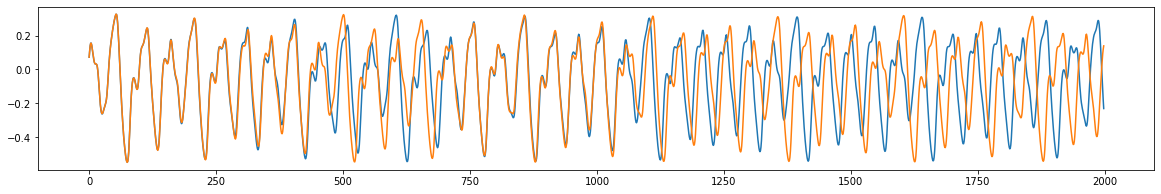

In [11]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(ESN_traject_ref)
plt.plot(ESN_traject_perturbed)

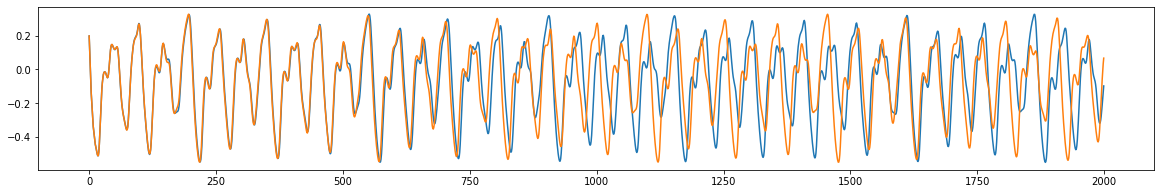

In [12]:
plt.rcParams["figure.figsize"] = (20,3)
plt.plot(MG_traject_ref)
plt.plot(MG_traject_perturbed)

In [13]:
ld_ls

[0.0056362621474416695,
 0.005892265965327751,
 0.0030488162090373163,
 0.003085390691689409,
 0.004578873544530265,
 0.006774957280059318,
 0.0035134132219060863,
 0.005966354138005599,
 0.005030130305186994,
 0.0027124008606093392,
 0.004549125234963664,
 0.006114678754888546,
 0.0051587511984086745,
 0.006434481887502055,
 0.004508515630601407,
 0.005047174489085935,
 0.003036984042280597,
 0.0062878499699951,
 0.006252917250839984,
 0.006383689811062982,
 0.005927606974716515,
 0.005737272926429227,
 0.005945652743389239,
 0.005168009251841152,
 0.0004751049416931837,
 0.006013271711090361,
 0.0046823418503615915,
 0.0060526447779062935,
 0.007224618678775192,
 0.0048695600358561785,
 0.0058319031420680035,
 0.00606885758455858,
 0.006006378820352948,
 0.0061861396580298374,
 0.005542941199882704,
 0.00526338215838591,
 0.003929933268359027,
 0.0052892124105857405,
 0.005774436160702793,
 0.004445509922709561,
 0.005386639228717983,
 -0.001732874861351858,
 0.0062367611351872585,
 